In [11]:
#increase the display size to 95% of window width
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:95% !important; }</style>"))

import os
import gc
import xarray as xr
import numpy as np


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
import glob
import pylab as pl
import mpl_toolkits.axisartist
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)
from matplotlib.colors import LogNorm
import string

from functions.mandyocIO import read_mandyoc_output, read_datasets, read_particle_path, single_plot, change_dataset, _extract_interface

path = os.getcwd().split('/')
machine_path = '/'+path[1]+'/'+path[2] #cat the /home/user/ or /Users/user from system using path

##File of fancy plot style. To use des.mplstyle file you must have an LaTeX distribution in your system
plt.style.use(machine_path+'/opt/mandyoc-scripts/sty/mandyoc.mplstyle')

In [104]:
def find_nearest(array, value):
    '''Return the index in array nearest to a given value.
    
    Parameters
    ----------
    
    array: array_like
        1D array used to find the index
        
    value: float
        Value to be seached
    '''
    
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def _log_fmt(x, pos):
    return "{:.0f}".format(np.log10(x))

def plot_instants(ax, axs, datasets, dataset, prop, xlims = [0, 1600],  ylims = [-700+40, 0 + 40]):
    
    label_size=20
    plt.rc('xtick', labelsize = label_size)
    plt.rc('ytick', labelsize = label_size)
    
    props_label = {'density':              r'$\mathrm{[kg/m^3]}$',
                   'radiogenic_heat':      'log(W/kg)',
                   'lithology':            r'log$(\epsilon_{II})$',
                   'pressure':             'P [GPa]',
                   'strain':               r'Accumulated strain [$\varepsilon$]',
                   'strain_rate':          r'log($\dot{\varepsilon}$)',
                   'temperature':          r'$^{\circ}\mathrm{[C]}$',
                   'temperature_anomaly':  r'Temperature anomaly $^{\circ}\mathrm{[C]}$',
                   'topography':           'Topography [km]',
                   'viscosity':            'log(Pa.s)',
                   'vs_anomaly':           r'dVs/Vs [\%]'
                   }
    
    props_cmap = {'density': 'viridis',
                  'radiogenic_heat': 'inferno',
                  'lithology': 'viridis',
                  'pressure': 'viridis',
                  'strain': 'viridis', #Default. Comment this line and uncomment one of the options bellow
#                   'strain': 'Greys',
#                   'strain': 'inferno',
                  'strain_rate': 'viridis',
                  'temperature': 'viridis',
                  'temperature_anomaly': 'RdBu_r',
                  'topography': '',
                  'viscosity': 'viridis'
                   }
    
#     vals_minmax = {'density':             [0.0, float(datasets.density.max())],
#                    'heat':                [float(datasets.radiogenic_heat.min()), float(datasets.radiogenic_heat.max())],
#                    'lithology':           [None, None],
#                    'pressure':            [float(datasets.pressure.min())/1.0e9, float(datasets.pressure.max())/1.0e9],
#                    'strain':              [None, None],
#                    'strain_rate':         [float(datasets.strain_rate.min()), float(datasets.strain_rate.max())],
#                    'temperature':         [0, float(datasets.temperature.max())],
#                    'temperature_anomaly': [-150, 150],
#                    'surface':             [float(datasets.surface.min())/1.0e3 + 40, float(datasets.surface.max())/1.0e3 + 40],
#                    'viscosity':           [float(datasets.viscosity.min()), float(datasets.viscosity.max())]
#                   }

#     vals_minmax = {'density':             [0.0, 3378.],
#                    'radiogenic_heat':     [1.0E-13, 1.0E-9],
#                    'lithology':           [None, None],
#                    'pressure':            [-1.0E-3, 1.0],
#                    'strain':              [None, None],
#                    'strain_rate':         [1.0E-19, 1.0E-14],
# #                    'strain_rate':         [np.log10(1.0E-19), np.log10(1.0E-14)],
#                    'temperature':         [0, 1600],
#                    'temperature_anomaly': [-150, 150],
#                    'surface':             [-6, 6],
#                    'viscosity':           [1.0E18, 1.0E25],
# #                    'viscosity':           [np.log10(1.0E18), np.log10(1.0E25)]
#                   }

    Nx = int(dataset.nx)
    Nz = int(dataset.nz)
    Lx = float(dataset.lx)
    Lz = float(dataset.lz)
    
    xi = np.linspace(0, Lx/1000, Nx)
    zi = np.linspace(-Lz/1000+40, 0+40, Nz) #km, +40 to compensate the air layer above sea level
    xx, zz = np.meshgrid(xi, zi)
    
    air_thickness = 40.0 #km
    
    if (prop != 'surface'):
        trash=1
        # xlims = [0, float(dataset.x.max()) / 1.0e3]
        # ylims = [-Lz / 1.0e3 + air_thickness, 0 + air_thickness]
        # xlims = [300, 1000]
        # ylims = [-100, 0 + air_thickness]
    else:
        xlims = [0, float(dataset.x.max()) / 1.0e3]
        ylims = [np.floor(float(dataset[prop].min()) / 1.0e3 + air_thickness), np.ceil(float(dataset[prop].max()) / 1.0e3 + air_thickness)]
        
        
#     val_minmax = vals_minmax[prop]
    
    #Dealing with data
    if(prop == 'lithology'):
        data = dataset['strain']
        vals_minmax = [None, None]
        
    elif(prop == 'temperature_anomaly'):
        #removing horizontal mean temperature
        A = dataset['temperature']
        B = A.T #shape: (Nz, Nx)
        C = np.mean(B, axis=1) #shape: 151==Nz
        D = (B.T - C) #B.T (Nx,Nz) para conseguir subtrair C
        data = D
        val_minmax = [-150, 150]
        
    elif(prop == 'surface'):
#         topo_from_density = True
        topo_from_density = False
        
        if(topo_from_density == True):
            Rhoi = dataset.density.T
            interfaces=[2900, 3365]
            ##Extract layer topography
            z = np.linspace(Lz/1000.0, 0, Nz)
            Z = np.linspace(Lz/1000.0, 0, 8001) #zi
            x = np.linspace(Lx/1000.0, 0, Nx)

            topo_interface = _extract_interface(z, Z, Nx, Rhoi, 300.) #200 kg/m3 = air/crust interface
            
            condx = (xi >= 100) & (xi <= 600)
            z_mean = np.mean(topo_interface[condx])
            
            topo_interface -= np.abs(z_mean)
            topo_interface = -1.0*topo_interface

            data = topo_interface
        else:
            data = dataset.surface/1.0e3 + 40.0 #km + air layer correction
            
        val_minmax = [datasets[prop].min()/1.0e3 + air_thickness, datasets[prop].max()/1.0e3 + air_thickness]
            
    elif(prop == 'pressure'):
        data = dataset[prop]/1.0E9 #GPa
        val_minmax = [datasets[prop].min()/1.0E9, datasets[prop].max()/1.0E9]
        
    elif(prop == 'viscosity' or prop == 'radiogenic_heat' or prop == 'strain_rate'):
        data = dataset[prop]
        data_new = data.where(data > 0, np.maximum(data, 1.0e-28))
        data = np.log10(data_new)
        
        datasets_aux = datasets[prop]
        datasets_aux = datasets.where(datasets > 0, np.maximum(datasets, 1.0e-28))
        datasets_aux = np.log10(datasets_aux)
        val_minmax = [np.log10(1.0E18), np.log10(1.0E25)]
#         val_minmax = [datasets_aux[prop].min(), datasets_aux[prop].max()]
        
    elif(prop == 'strain'):
        data = dataset[prop]
        val_minmax = [None, None]
        
    else:
        data = dataset[prop]
        val_minmax = [datasets[prop].min(), datasets[prop].max()]
        
    #Plot data
    if(prop != 'topography'): #Plot isotherms
        Temperi = dataset.temperature.T
        
        isotherms=[550, 800, 1300]
        isot_colors = []
        for isotherm in isotherms:
            isot_colors.append('red')
            
        cs = ax.contour(xx, zz, Temperi, 100, levels=isotherms, colors=isot_colors)
        
        # if(ax == axs[0]):
        #     fmt = {}
        #     for level, isot in zip(cs.levels, isotherms):
        #         fmt[level] = str(level) + r'$^{\circ}$C'

        #     ax.clabel(cs, cs.levels, fmt=fmt, inline=True, use_clabeltext=True)
        
    if (prop == 'density' or prop == 'pressure' or prop == 'radiogenic_heat' or prop == 'strain_rate' or prop == 'temperature' or prop == 'temperature_anomaly' or prop == 'viscosity'): #properties that need a regular colorbar
        im = ax.imshow(data.T,
                       cmap = props_cmap[prop],
                       origin='lower',
                       extent = (0, Lx / 1.0E3, -Lz / 1.0E3 + 40, 0 + 40),
                       vmin=val_minmax[0], vmax=val_minmax[1],
                       aspect = 'auto')
        
        if(ax == axs[-1]):
            axins1 = inset_axes(ax,
                                width="30%",  # width: 30% of parent_bbox width
                                height="5%",  # height: 5%
                                bbox_to_anchor=(-0.02, -0.66, 1, 1),
                                bbox_transform=ax.transAxes,
                                )

    #         ticks = np.linspace(val_minmax[0], val_minmax[1], 6, endpoint=True)

            #precision of colorbar ticks
            if(prop == 'pressure'): 
                fmt = '%.2f'
            else:
                fmt = '%.0f'
            
            ticks = np.linspace(np.round(val_minmax[0], 0), np.round(val_minmax[1], 0), 5, endpoint=True, dtype=int)
            im.set_clim(np.round(val_minmax[0], 0), np.round(val_minmax[1], 0)) #to force the ticks at the edges of the colorbar
            # ticks = [0, 500, 1000, 1500]#np.linspace(0, 1500, 4, endpoint=True, dtype=int)
            print(ticks)
            clb = fig.colorbar(im,
                               cax=axins1,
                               ticks=ticks,
                               spacing = 'proportional',
                               orientation='horizontal',
                               fraction=0.08,
                               pad=0.2,
                               format=fmt)

            clb.set_label(props_label[prop], fontsize=12)
            clb.minorticks_off()
        
    elif (prop == 'strain'):
        im = ax.imshow(data.T,
                       cmap = props_cmap[prop],
                       origin='lower',
                       extent = (0, Lx / 1.0E3, -Lz / 1.0E3 + 40, 0 + 40),
                       vmin = float(data.min()),
                       vmax = float(data.max()),
                       aspect = 'auto')
        
        axins1 = inset_axes(ax,
                            width="30%",  # width: 30% of parent_bbox width
                            height="5%",  # height: 5%
                            bbox_to_anchor=(-0.02, -0.58, 1, 1),
                            bbox_transform=ax.transAxes,
                            )

            
#         ticks = np.linspace(val_minmax[0], val_minmax[1], 5, endpoint=True, dtype=int)
        ticks = np.arange(float(data.min()), float(data.max()), 5)
        fmt = '%.0f'
        clb = fig.colorbar(im,
                           cax=axins1,
#                            ax=ax,
                           ticks=ticks,
                           orientation='horizontal',
                           fraction=0.08,
                           pad=0.2,
                           format=fmt)

        clb.set_label(props_label[prop], fontsize=12)
        clb.minorticks_off()
        clb.set_label(props_label[prop], fontsize=12)
        
    elif(prop == 'surface'):
        ax.plot(dataset.x/1.0e3, data, alpha = 1, linewidth = 2.0, color = "blueviolet")
        
    elif(prop == 'lithology'): #shaded lithology plot
        cr = 255.
        color_uc = (228. / cr, 156. / cr, 124. / cr)
        color_lc = (240. / cr, 209. / cr, 188. / cr)
        color_lit = (155. / cr, 194. / cr, 155. / cr)
        color_ast = (207. / cr, 226. / cr, 205. / cr)
        
        Rhoi = dataset.density.T
        interfaces=[2900, 3365]
        
        ##Extract layer topography
        z = np.linspace(Lz/1000.0, 0, Nz)
        Z = np.linspace(Lz/1000.0, 0, 8001) #zi
        x = np.linspace(Lx/1000.0, 0, Nx)
            
        topo_interface = _extract_interface(z, Z, Nx, Rhoi, 300.) #200 kg/m3 = air/crust interface
        condx = (xi >= 100) & (xi <= 600)
        z_mean = np.mean(topo_interface[condx])
        topo_interface -= np.abs(z_mean)
        topo_interface = -1.0*topo_interface
        
        ax.contourf(xx,
                    zz,
                    Rhoi,
                    levels = [200., 2750, 2900, 3365, 3900],
                    colors = [color_uc, color_lc, color_lit, color_ast])
        
        im=ax.imshow(data.T,
                     cmap = 'Greys',
                     origin = 'lower',
                     extent = (0, Lx / 1.0E3, -Lz / 1.0E3 + 40,0 + 40),
#                      extent = (300, 1100, -300, 40),
                     zorder = 50,
                     alpha = 0.2, vmin=-0.5,
                     vmax = 0.7,
                     aspect = 'auto')
        #legend box
        if(ax == axs[-1]):
            b1 = [0.89, #horizontal position
                    0.18, #vertical position
                    0.09, #horizontal shift
                    0.09  #scale
                    ]
                    
            bv1 = plt.axes(b1)
            A = np.zeros((100, 10))

            A[:25, :] = 2700
            A[25:50, :] = 2800
            A[50:75, :] = 3300
            A[75:100, :] = 3400

            A = A[::-1, :]

            xA = np.linspace(-0.5, 0.9, 10)
            yA = np.linspace(0, 1.5, 100)

            xxA, yyA = np.meshgrid(xA, yA)
            air_threshold = 200
            plt.contourf(
                xxA,
                yyA,
                A,
                levels=[air_threshold, 2750, 2900, 3365, 3900],
                colors=[color_uc, color_lc, color_lit, color_ast],
            )

            plt.imshow(
                xxA[::-1, :],
                extent=[-0.5, 0.9, 0, 1.5],
                zorder=100,
                alpha=0.2,
                cmap=plt.get_cmap("Greys"),
                vmin=-0.5,
                vmax=0.9,
            )

            bv1.set_yticklabels([])
            plt.xlabel(r"log$(\varepsilon_{II})$", size=14)
            bv1.tick_params(axis='x', which='major', labelsize=12)
            bv1.set_xticks([-0.5, 0, 0.5])
            bv1.set_yticks([])
            bv1.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
            
    if(prop != 'surface'):
        #Filling above topographic surface
        Rhoi = dataset.density.T
        interfaces=[2900, 3365]
        ##Extract layer topography
        z = np.linspace(Lz/1000.0, 0, Nz)
        Z = np.linspace(Lz/1000.0, 0, 8001) #zi
        x = np.linspace(Lx/1000.0, 0, Nx)

        topo_interface = _extract_interface(z, Z, Nx, Rhoi, 300.) #200 kg/m3 = air/crust interface
        condx = (xi >= 100) & (xi <= 600)
        z_mean = np.mean(topo_interface[condx])
        topo_interface -= np.abs(z_mean)
        topo_interface = -1.0*topo_interface

        xaux = xx[0]
        condaux = (xaux>xlims[0]) & (xaux<xlims[1])
        xaux = xaux[condaux]

        ax.fill_between(xaux, topo_interface[condaux], 39, color='white', alpha=1.0, zorder=51)
        
#         ax.set_xlim(xlims)
#         ax.set_ylim(ylims)
# #         ax.set_xlim([300, 1100])
# #         ax.set_ylim([-300+40, 40])
# #         ax.set_yticks([-200, -100, 0])
#         if(instant == instants[-1]):
#             ax.set_xlabel("Distance (km)", fontsize = label_size)
#         ax.set_ylabel("Depth (km)", fontsize = label_size)
        
        
        # if(len(instants)>1):
        #     label_text = f"{letter}){str(instant)} Myr"
        # else:
        #     label_text = f"{letter}{str(instant)} Myr"
        # fsize = 20
        # ax.text(0.015,
        #         0.90,
        #         label_text,
        #         color='k',
        #         bbox=dict(edgecolor = 'white',
        #                   facecolor = 'white',
        #                   alpha = 0.6),
        #         fontsize=fsize,
        #         horizontalalignment='left',
        #         verticalalignment='center',
        #         transform=ax.transAxes,
        #         zorder=52)
        
    else:
        ax.grid('-k', alpha=0.7)
        # ax.set_xlim(xlims)
        # ax.set_ylim(ylims)
        
        # yticks = np.arange(ylims[0], ylims[1], 1)
        # ax.set_yticks(yticks)
        # if(instant == instants[-1]):
        #     ax.set_xlabel("Distance (km)", fontsize = label_size)
            
        # ax.set_ylabel("Topography (km)", fontsize = label_size)

Margin_geometries_30Myr_lit150km_lithology


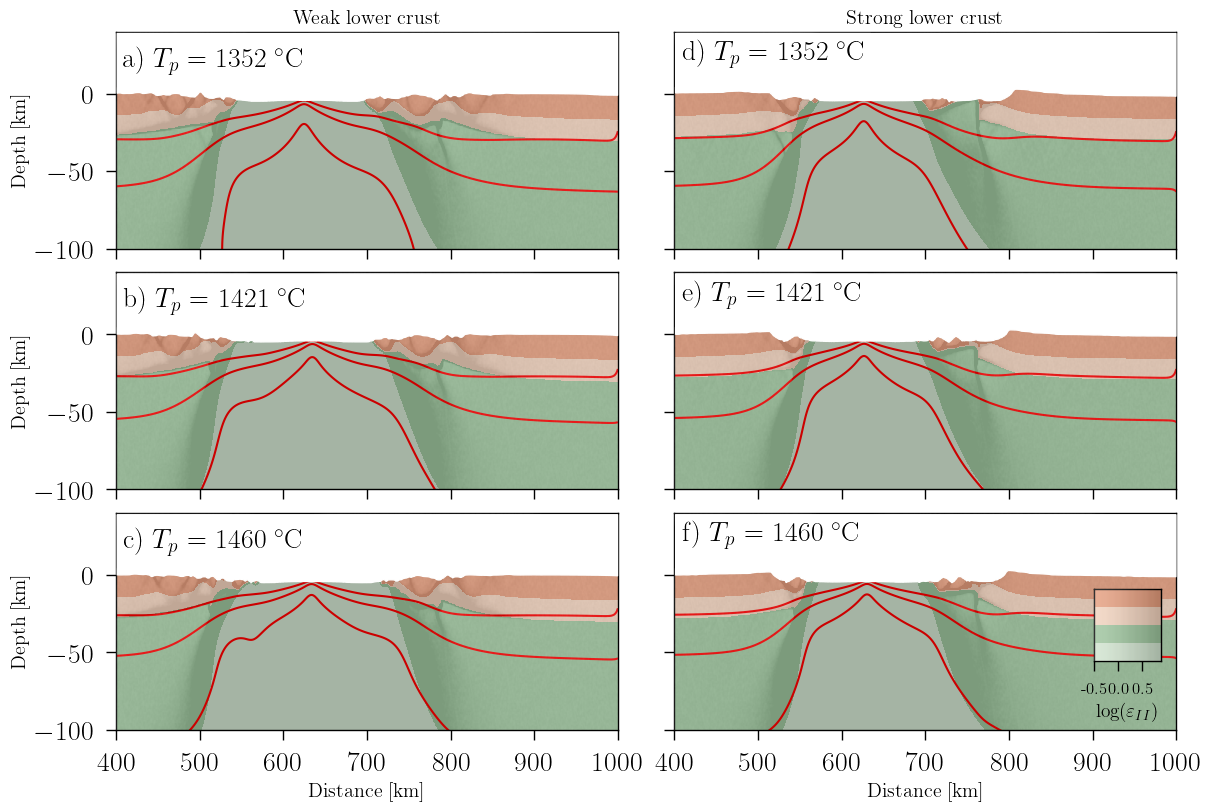

In [106]:
output = [#Properties from mandyoc. Comment/uncomment to select witch one you would like to plot
#              'density',
#              'radiogenic_heat',
             'lithology',
#              'pressure',
#              'strain',
#              'strain_rate',
            #  'temperature',
            #  'temperature_anomaly',
#              'surface',
            #  'viscosity'
             ]
prop = output[0]
################################################################################################################################

plot_isotherms = True

# #Read datasets
# # local = True
# local = False
# if(local==True):
#     model_path = machine_path + scenario
# else:
#     # scenario = '/RFT_Clc1_DT200_PT1292oC_lit80km_1x1km2_NHK'
#     external_media = 'Joao_Macedo'
#     model_path = f'/media/joao_macedo/{external_media}{scenario}'

# datasets = xr.open_dataset(f"{model_path}/data.nc")

#Set instants

instants = [30]

#RFT
# scenarios = ['/Doutorado/cenarios/mandyoc/rifting/v1/lit80km/DT200_PT1292oC/1x1km2/NHK/RFT_Clc1_DT200_PT1292oC_lit80km_1x1km2_NHK',
#              '/Doutorado/cenarios/mandyoc/rifting/v1/lit150km/DT200_PT1352oC/1x1km2/NHK/RTF_Clc1_DT200_PT1352oC_lit150km_1x1km2_NHK',

#             '/Doutorado/cenarios/mandyoc/rifting/v1/lit80km/DT290_PT1350oC/1x1km2/NHK/RFT_Clc1_DT290_PT1350oC_lit80km_1x1km2_NHK',
#             '/Doutorado/cenarios/mandyoc/rifting/v1/lit150km/DT290_PT1421oC/1x1km2/NHK/RFT_Clc1_DT290_PT1421oC_lit150km_1x1km2_NHK',

#             '/Doutorado/cenarios/mandyoc/rifting/v1/lit80km/DT350_PT1397oC/1x1km2/NHK/RFT_Clc1_DT350_PT1397oC_lit80km_1x1km2_NHK',
#             '/Doutorado/cenarios/mandyoc/rifting/v1/lit150km/DT350_PT1460oC/1x1km2/NHK/RTF_Clc1_DT350_PT1460oC_lit150km_1x1km2_NHK',
#             ]

# scenarios = ['/Doutorado/cenarios/mandyoc/rifting/v1/lit80km/DT200_PT1292oC/1x1km2/NHK/RFT_Clc10_DT200_PT1292oC_lit80km_1x1km2_NHK',
#             '/Doutorado/cenarios/mandyoc/rifting/v1/lit80km/DT290_PT1350oC/1x1km2/NHK/RFT_Clc10_DT290_PT1350oC_lit80km_1x1km2_NHK',
#             '/Doutorado/cenarios/mandyoc/rifting/v1/lit80km/DT350_PT1397oC/1x1km2/NHK/RFT_Clc10_DT350_PT1397oC_lit80km_1x1km2_NHK',
#             '/Doutorado/cenarios/mandyoc/rifting/v1/lit150km/DT200_PT1352oC/1x1km2/NHK/RTF_Clc10_DT200_PT1352oC_lit150km_1x1km2_NHK',
#             '/Doutorado/cenarios/mandyoc/rifting/v1/lit150km/DT290_PT1421oC/1x1km2/NHK/RFT_Clc10_DT290_PT1421oC_lit150km_1x1km2_NHK',
#             '/Doutorado/cenarios/mandyoc/rifting/v1/lit150km/DT350_PT1460oC/1x1km2/NHK/RFT_Clc10_DT350_PT1460oC_lit150km_1x1km2_NHK',
#             ]

# scenarios = ['/Doutorado/cenarios/mandyoc/rifting/v1/lit80km/DT200_PT1292oC/1x1km2/NHK/RFT_Clc1_DT200_PT1292oC_lit80km_1x1km2_NHK',
#              '/Doutorado/cenarios/mandyoc/rifting/v1/lit80km/DT200_PT1292oC/1x1km2/NHK/RFT_Clc10_DT200_PT1292oC_lit80km_1x1km2_NHK',

#             '/Doutorado/cenarios/mandyoc/rifting/v1/lit80km/DT290_PT1350oC/1x1km2/NHK/RFT_Clc1_DT290_PT1350oC_lit80km_1x1km2_NHK',
#             '/Doutorado/cenarios/mandyoc/rifting/v1/lit80km/DT290_PT1350oC/1x1km2/NHK/RFT_Clc10_DT290_PT1350oC_lit80km_1x1km2_NHK',

#             '/Doutorado/cenarios/mandyoc/rifting/v1/lit80km/DT350_PT1397oC/1x1km2/NHK/RFT_Clc1_DT350_PT1397oC_lit80km_1x1km2_NHK',
#             '/Doutorado/cenarios/mandyoc/rifting/v1/lit80km/DT350_PT1397oC/1x1km2/NHK/RFT_Clc10_DT350_PT1397oC_lit80km_1x1km2_NHK',
#             ]

scenarios = ['/Doutorado/cenarios/mandyoc/rifting/v1/lit150km/DT200_PT1352oC/1x1km2/NHK/RTF_Clc1_DT200_PT1352oC_lit150km_1x1km2_NHK',
            '/Doutorado/cenarios/mandyoc/rifting/v1/lit150km/DT200_PT1352oC/1x1km2/NHK/RTF_Clc10_DT200_PT1352oC_lit150km_1x1km2_NHK',
            '/Doutorado/cenarios/mandyoc/rifting/v1/lit150km/DT290_PT1421oC/1x1km2/NHK/RFT_Clc1_DT290_PT1421oC_lit150km_1x1km2_NHK',
            '/Doutorado/cenarios/mandyoc/rifting/v1/lit150km/DT290_PT1421oC/1x1km2/NHK/RFT_Clc10_DT290_PT1421oC_lit150km_1x1km2_NHK',
            '/Doutorado/cenarios/mandyoc/rifting/v1/lit150km/DT350_PT1460oC/1x1km2/NHK/RTF_Clc1_DT350_PT1460oC_lit150km_1x1km2_NHK',
            '/Doutorado/cenarios/mandyoc/rifting/v1/lit150km/DT350_PT1460oC/1x1km2/NHK/RTF_Clc10_DT350_PT1460oC_lit150km_1x1km2_NHK',
            ]

air_thickness = 40
xlims = [400, 1000]
ylims = [-100, 0 + air_thickness]

plt.close()
fig, axs = plt.subplots(int(len(scenarios)/2), 2, figsize=(12, 8), sharex=True, sharey=True, constrained_layout=True)
axs = axs.flatten()

for ax, scenario in zip(axs, scenarios):
    # local = True
    local = False
    if(local==True):
        model_path = machine_path + scenario
    else:
        # scenario = '/RFT_Clc1_DT200_PT1292oC_lit80km_1x1km2_NHK'
        external_media = 'Joao_Macedo'
        model_path = f'/media/joao_macedo/{external_media}{scenario}'
        
    #Read datasets
    datasets = xr.open_dataset(f"{model_path}/data.nc")

    idx = find_nearest(datasets.time, instants)
    dataset = datasets.isel(time=idx)
    
    plot_instants(ax, axs, datasets, dataset, prop, xlims, ylims)

############################################################################################################################################
#Plot details
alphabet = list(string.ascii_lowercase)
letters = alphabet[0: int(len(scenarios))]

letters_left = letters[0:3:1]
letters_right = letters[3::1]

# Tps = ['1292', '1350', '1397']
Tps = ['1352', '1421', '1460']

for ax, letter, i in zip(axs, letters, range(0, len(letters)+1, 1)):
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    
fsize = 20
for i in range(int(len(letters_left))):

    axs[2*i].text(0.015,
            0.87,
            f"{letters_left[i]}) $T_p$ = {Tps[i]}"+" $^{\circ}$C",
            color='k',
            bbox=dict(edgecolor = 'white',
                        facecolor = 'white',
                        alpha = 0.6),
            fontsize=fsize,
            horizontalalignment='left',
            verticalalignment='center',
            transform=axs[2*i].transAxes,
            zorder=52)
    
    axs[2*i+1].text(0.015,
            0.9,
            # f"{letters_right[i]}) $T_p$ = {Tps_right[i]}"+" $^{\circ}$C",
            f"{letters_right[i]}) $T_p$ = {Tps[i]}"+" $^{\circ}$C",
            color='k',
            bbox=dict(edgecolor = 'white',
                        facecolor = 'white',
                        alpha = 0.6),
            fontsize=fsize,
            horizontalalignment='left',
            verticalalignment='center',
            transform=axs[2*i+1].transAxes,
            zorder=52)
    
axs[-1].set_xlabel('Distance [km]')
axs[-2].set_xlabel('Distance [km]')

axs[0].title.set_text('Weak lower crust')
axs[1].title.set_text('Strong lower crust')

for i in range(0, len(scenarios), 2):
    axs[i].set_ylabel('Depth [km]')

# #Saving figure
savefig = True
# savefig = False

if(savefig == True):
    # figname = f"Margin_geometries_30Myr_lit80km_{prop}"
    figname = f"Margin_geometries_30Myr_lit150km_{prop}"
    print(figname)

    # #This will save inside the notebook directory
    fig.savefig(f"out/{figname}.pdf", dpi=400)
    fig.savefig(f"out/{figname}.png", dpi=400)

<xarray.Dataset>
Dimensions:          (x: 1001, z: 301, time: 152)
Coordinates:
  * x                (x) float64 0.0 1e+03 2e+03 ... 9.98e+05 9.99e+05 1e+06
  * z                (z) float64 -3e+05 -2.99e+05 -2.98e+05 ... -1e+03 0.0
  * time             (time) float64 0.0 0.5 1.0 1.5 ... 39.48 39.6 39.75 39.92
    step             (time) int32 ...
Data variables:
    density          (time, x, z) float64 ...
    radiogenic_heat  (time, x, z) float64 ...
    pressure         (time, x, z) float64 ...
    strain           (time, x, z) float64 ...
    strain_rate      (time, x, z) float64 ...
    temperature      (time, x, z) float64 ...
    viscosity        (time, x, z) float64 ...
    surface          (time, x) float64 ...
Attributes: (12/94)
    nx:                                1001
    nz:                                301
    lx:                                1000000.0
    lz:                                300000.0
    multigrid:                         1
    solver:                            direct
    ...                                ...
    temperature_units:                 C
    density_units:                     kg/m^3
    heat_units:                        W/m^3
    viscosity_units:                   Pa s
    strain_rate_units:                 s^(-1)
    pressure_units:                    Pa

In [51]:
for i in range(int(len(letters)/2)):
    print(2*i, 2*i+1)

0 1
2 3
4 5
6 7
8 9
10 11


In [61]:
letters[0:3:1], letters[3::1]

(['a', 'b', 'c'], 'd')